In [1]:
import mne
import matplotlib.pyplot as plt 
import numpy as np
from mne.preprocessing import ICA
label = ['S001R03.edf', 'S001R04.edf', 'S001R07.edf', 'S001R08.edf','S001R11.edf','S001R12.edf']
directory ="C:\\Users\\erdes\\OneDrive\\Documents\\bmi\\eeg-motor-movementimagery-dataset-1.0.0\\files\\S001\\"
n_files = len(label)
for x in range(n_files):
    print(x)
    raw_dir = directory + label[x]
    print(raw_dir)
    if x == 0: 
        raw = mne.io.read_raw_edf(raw_dir, preload=True)
    else :
        raw = mne.concatenate_raws([raw, mne.io.read_raw_edf(raw_dir, preload=True)])

power_line_frequency = 50  # Specify your local power-line frequency (e.g., 50 Hz or 60 Hz)
freqs = [power_line_frequency]
notch_filter_params = dict(freqs=freqs, method='spectrum_fit', filter_length='auto', notch_widths=2)
raw.notch_filter(**notch_filter_params)
raw.filter(l_freq=8, h_freq=20, picks='eeg')
montage = mne.channels.read_custom_montage("C:\\Users\\erdes\\Downloads\\Telegram Desktop\\BioSemi64.loc")
raw.set_montage(montage)


0
C:\Users\erdes\OneDrive\Documents\bmi\eeg-motor-movementimagery-dataset-1.0.0\files\S001\S001R03.edf
Extracting EDF parameters from C:\Users\erdes\OneDrive\Documents\bmi\eeg-motor-movementimagery-dataset-1.0.0\files\S001\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
1
C:\Users\erdes\OneDrive\Documents\bmi\eeg-motor-movementimagery-dataset-1.0.0\files\S001\S001R04.edf
Extracting EDF parameters from C:\Users\erdes\OneDrive\Documents\bmi\eeg-motor-movementimagery-dataset-1.0.0\files\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
2
C:\Users\erdes\OneDrive\Documents\bmi\eeg-motor-movementimagery-dataset-1.0.0\files\S001\S001R07.edf
Extracting EDF parameters from C:\Users\erdes\OneDrive\Documents\bmi\eeg-motor-movementimagery-dataset-1.0.0\files\S001\S001R07.edf...
EDF file

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawEDF | S001R03.edf, 64 x 120000 (750.0 s), ~58.7 MB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 40 components
Fitting ICA took 2.1s.


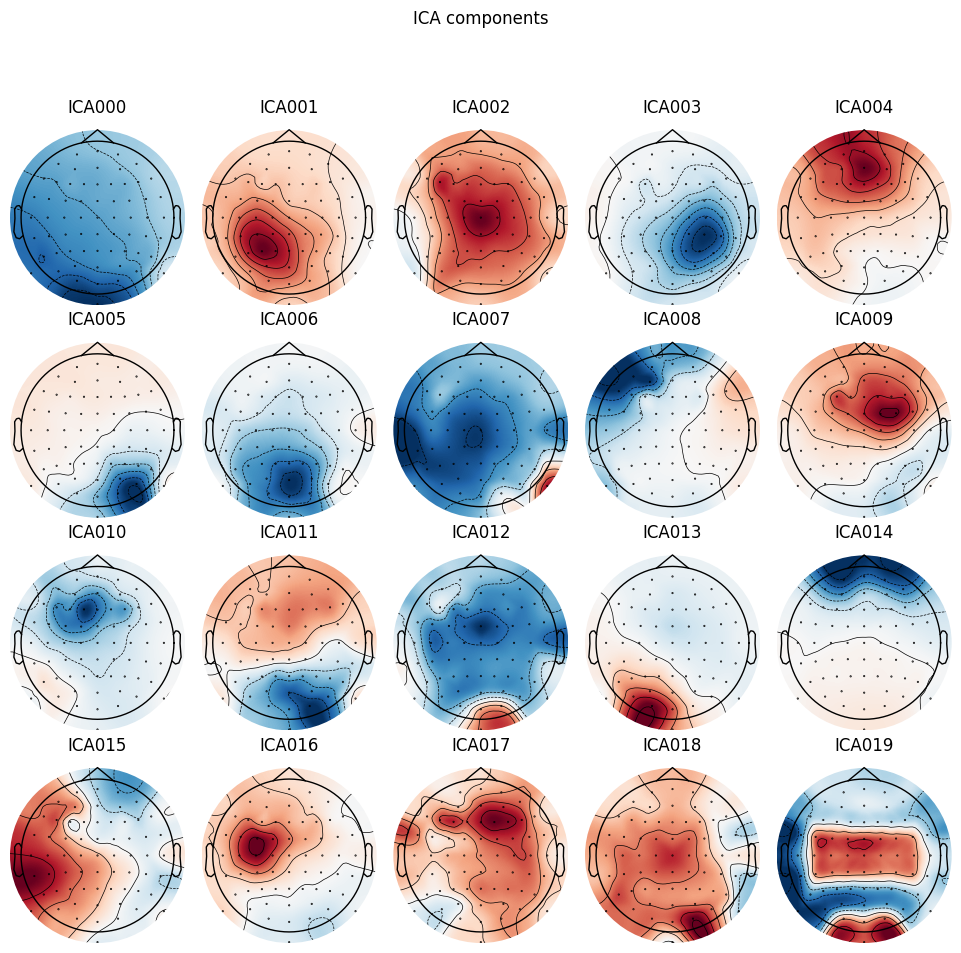

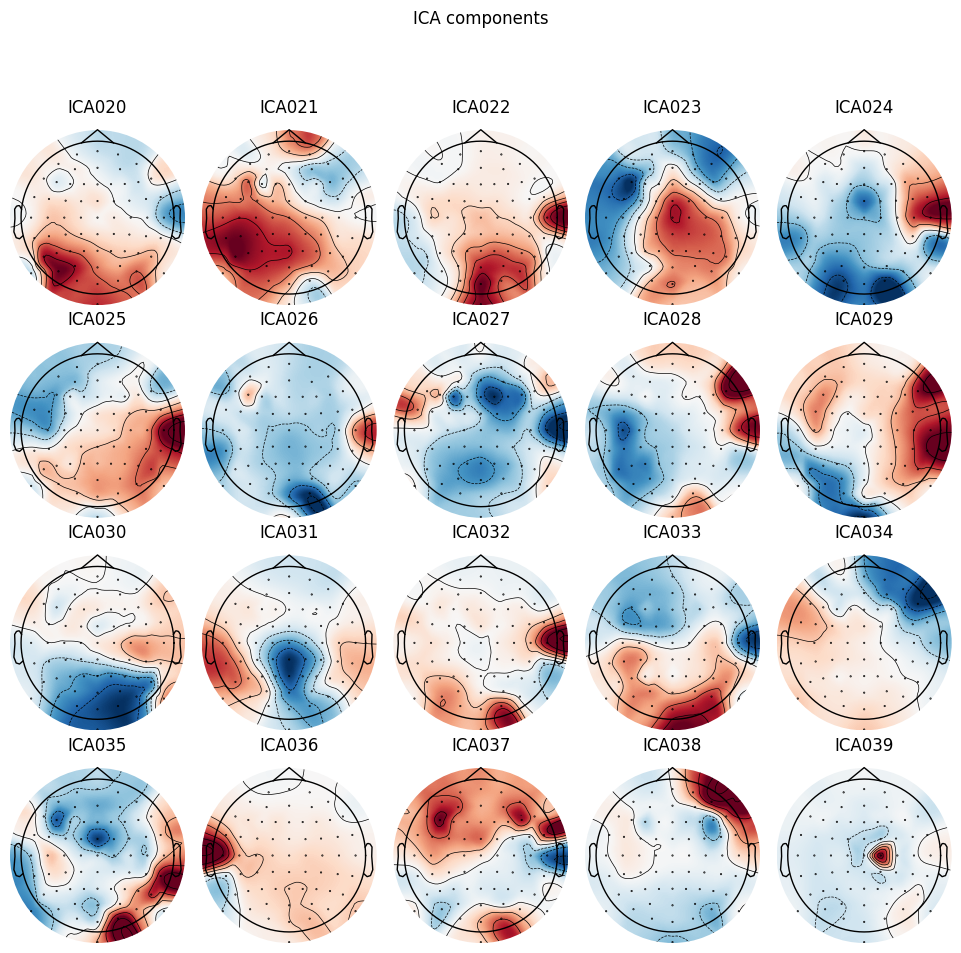

Creating RawArray with float64 data, n_channels=40, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.


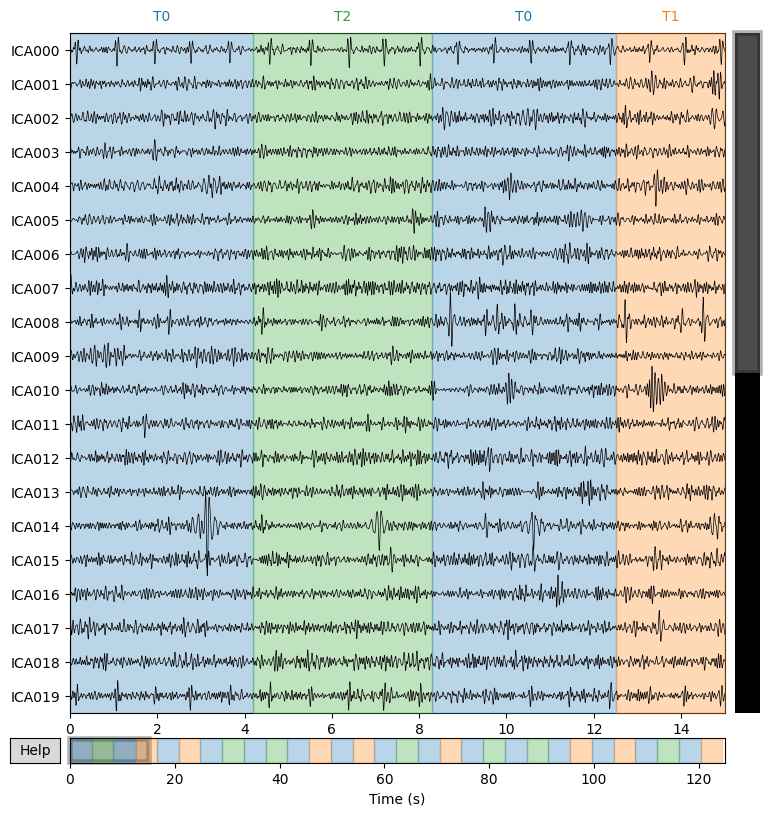

Creating RawArray with float64 data, n_channels=20, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.


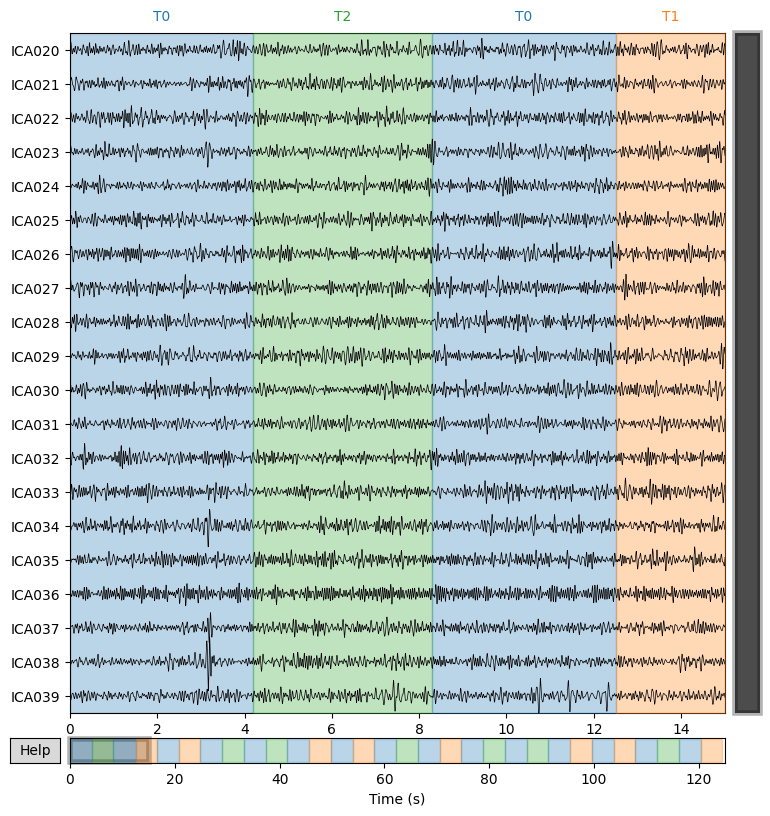

In [227]:
filt_raw = raw.copy().filter(l_freq=8, h_freq=30)
ica = ICA(n_components=40, max_iter="auto", random_state=97)
ica.fit(filt_raw)
ica.plot_components();
ica.plot_sources(raw, show_scrollbars=True, start=0, stop=15); 
ica.plot_sources(raw,picks=[20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], show_scrollbars=True, start=0, stop=15); 


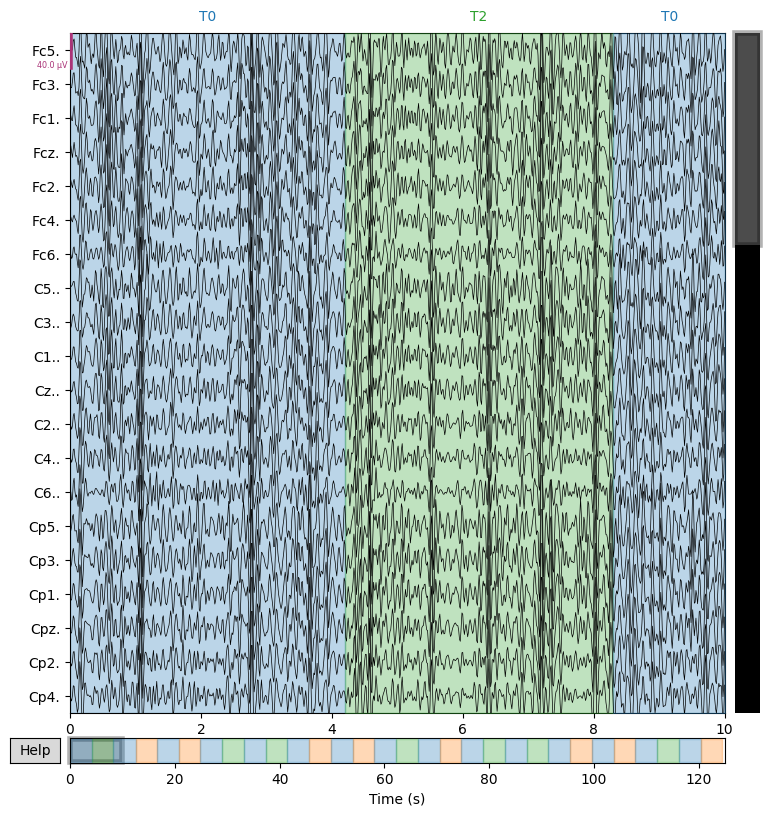

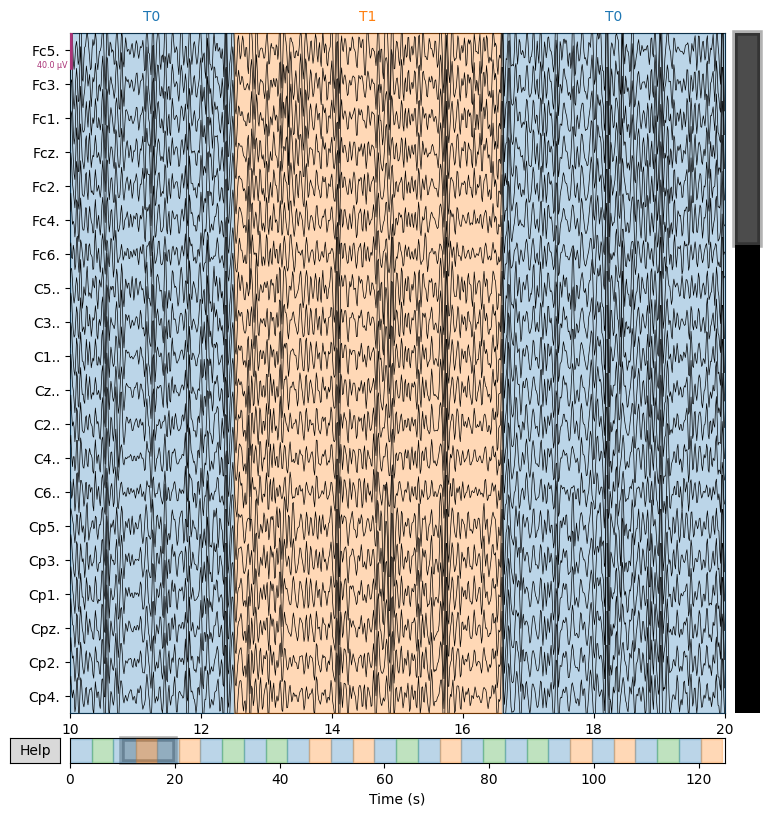

In [228]:
filt_raw.plot(duration=10, start=0);
filt_raw.plot(duration=10, start=10);

Applying ICA to Raw instance
    Transforming to ICA space (40 components)
    Zeroing out 14 ICA components
    Projecting back using 64 PCA components


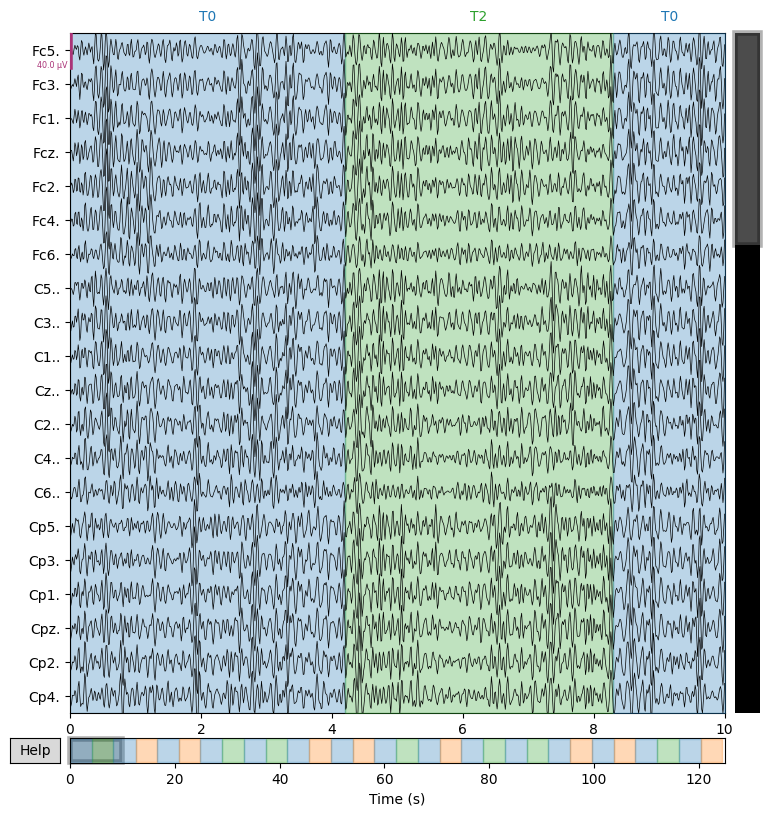

In [229]:
ica.exclude = [0,4,5,7,8,13,14,19,21,23,28,29,34,38]
#40 [0,2,4,5,7,6,11,12,16,28,35,37]
#30 ch [0,6,7,9,15,17,22,24,25,26,28,4,12,14]
ica.apply(filt_raw, exclude=ica.exclude).plot(start=0,duration=10);

In [230]:
sample_rate=160
EEG = filt_raw.get_data()
nchannels, nsamples = raw.get_data().shape
channel_names = raw.ch_names
events, _ = mne.events_from_annotations(raw)
event_onsets = np.zeros((1,30), dtype=int)
for i in range(30):
    event_onsets[0][i] =  events[ :,0][i]
event_codes = np.zeros((1,30), dtype=int)
for i in range(30):
    event_codes[0][i] =  events[ :,2][i]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = ['T0','T1','T2']
cl0 = cl_lab[0]
cl1 = cl_lab[1]
cl2 = cl_lab[2]
nclasses = len(cl_lab)
nevents = len(event_onsets)

Used Annotations descriptions: ['T0', 'T1', 'T2']


In [231]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(-0.1*sample_rate), int(4*sample_rate))

# Length of the time window
nsamples = len(win)

In [232]:
# Loop over the classes (right, left)
for cl, code in zip(cl_lab, np.unique(event_codes)):

    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]

    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))

    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]

# Some information about the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl0]:', trials[cl0].shape)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl0]: (64, 656, 15)
Shape of trials[cl1]: (64, 656, 8)
Shape of trials[cl2]: (64, 656, 7)


In [233]:
from matplotlib import mlab

def psd(trials):
    '''
    Calculates for each trial the Power Spectral Density (PSD).

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal

    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.
    freqs : list of floats
        Yhe frequencies for which the PSD was computed (useful for plotting later)
    '''

    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 329, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)

            trials_PSD[ch, :, trial] = PSD.ravel()

    return trials_PSD, freqs

In [234]:
# Apply the function
psd_rest, freqs = psd(trials[cl0])
psd_r, freqs = psd(trials[cl1])
psd_l, freqs = psd(trials[cl2])
trials_PSD = {cl0: psd_rest, cl1: psd_r, cl2: psd_l}

In [235]:

import matplotlib.pyplot as plt

In [236]:
def plot_psd(trials_PSD, freqs, chan_ind,
             chan_lab=None, maxy=None):
    '''
    Plots PSD data calculated with psd()

    Parameters
    ----------
    trials : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd()
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    plt.figure(figsize=(12,5))

    nchans = len(chan_ind)

    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)

    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows, ncols,i+1)

        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
        
        # All plot decoration below...
        plt.xlim(1,30)
        if maxy != None:
            plt.ylim(0,maxy)

        plt.grid()
        plt.xlabel('Frequency (Hz)')

        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    

    plt.tight_layout()
    


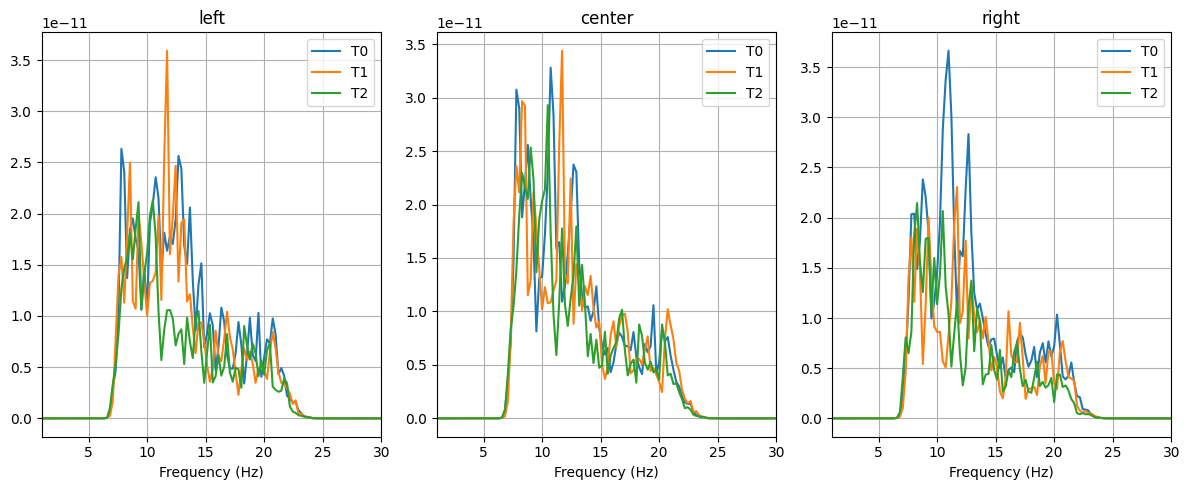

In [237]:
plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3..', 'Cz..', 'C4..']],
    chan_lab=['left', 'center', 'right'],
    maxy=None
)

In [238]:
from scipy import signal

def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)

    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''

    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = signal.filtfilt(a, b, trials[:,:,i], axis=1)

    return trials_filt



In [239]:
# Apply the function
trials_filt = {cl0: bandpass(trials[cl0], 8, 15, sample_rate), cl1: bandpass(trials[cl1], 8, 15, sample_rate),
               cl2: bandpass(trials[cl2], 8, 15, sample_rate)}

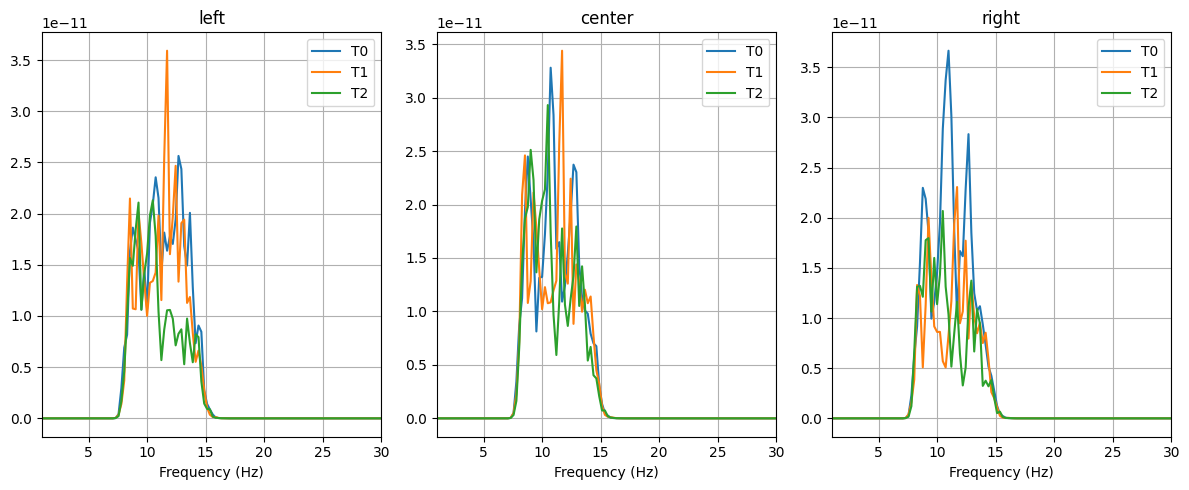

In [240]:
psd_rest, freq = psd(trials_filt[cl0])
psd_r, freqs = psd(trials_filt[cl1])
psd_l, freqs = psd(trials_filt[cl2])
trials_PSD = {cl0: psd_rest, cl1: psd_r, cl2: psd_l}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3..', 'Cz..', 'C4..']],
    chan_lab=['left', 'center', 'right'],
    maxy=None
)


In [241]:
# Calculate the log(var) of the trials
def logvar(trials):
    '''
    Calculate the log-var of each channel.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal.

    Returns
    -------
    logvar - 2d-array (channels x trials)
        For each channel the logvar of the signal
    '''
    return np.log(np.var(trials, axis=1))

In [242]:
# Apply the function
trials_logvar = {cl0: logvar(trials_filt[cl0]),
                cl1: logvar(trials_filt[cl1]),
                 cl2: logvar(trials_filt[cl2])}


In [243]:
def plot_logvar(trials):
    '''
    Plots the log-var of each channel/component.
    arguments:
        trials - Dictionary containing the trials (log-vars x trials) for 3 classes.
    '''
    plt.figure(figsize=(12,5))

    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4
    x2 = np.arange(nchannels) + 0.8

    y0 = np.mean(trials[cl0], axis=1)
    y1 = np.mean(trials[cl1], axis=1)
    y2 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')
    plt.bar(x2, y2, width=0.5, color='g')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(cl_lab)
    

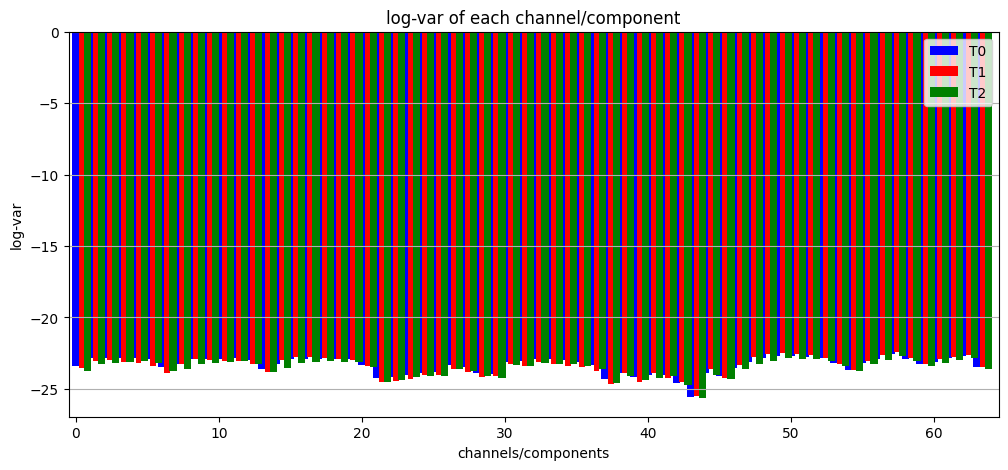

In [244]:
# Plot the log-vars
plot_logvar(trials_logvar)

In [245]:
from numpy import linalg

def cov(trials):
    ''' Calculate the covariance for each trial and return their average '''
    ntrials = trials.shape[2]
    covs = [trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials)]
    return np.mean(covs, axis=0)

def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    U, l, _ = linalg.svd(sigma)
    return U.dot(np.diag(l ** -0.5) )

def csp(trials_rest, trials_r, trials_l):
    '''
    Calculate the CSP transformation matrix W.
    arguments:
        trials_r - Array (channels x samples x events) containing right hand movement trials
        trials_f - Array (channels x samples x trials) containing left movement trials
    returns:
        Mixing matrix W
    '''
    cov_rest = cov(trials_rest)
    cov_r = cov(trials_r)
    cov_l = cov(trials_l)
    P = whitening(cov_rest + cov_r + cov_l)
    B, _, _ = linalg.svd(P.T.dot(cov_l).dot(P))
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ''' Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)'''
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [246]:
# Apply the functions
W = csp(trials_filt[cl0], trials_filt[cl1], trials_filt[cl2])

In [247]:
trials_csp = {cl0: apply_mix(W, trials_filt[cl0]),
              cl1: apply_mix(W, trials_filt[cl1]),
              cl2: apply_mix(W, trials_filt[cl2])}


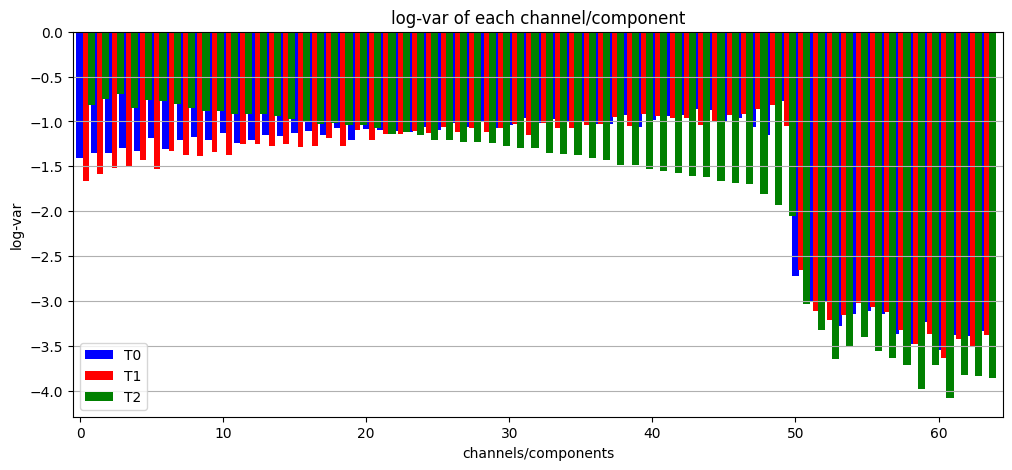

In [248]:
trials_logvar = {cl0: logvar(trials_csp[cl0]),
                 cl1: logvar(trials_csp[cl1]),
                 cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

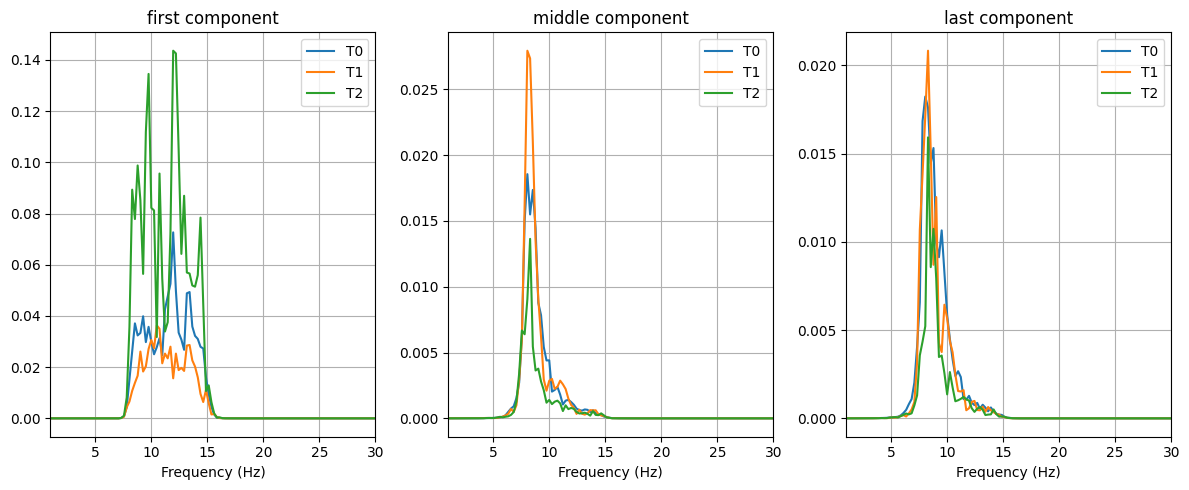

In [249]:
psd_rest, freqs = psd(trials_csp[cl0])
psd_r, freqs = psd(trials_csp[cl1])
psd_l, freqs = psd(trials_csp[cl2])
trials_PSD = {cl0: psd_rest, cl1: psd_r, cl2: psd_l}

plot_psd(trials_PSD, freqs, [0, 58, -1], chan_lab=['first component', 'middle component', 'last component'], maxy=None)

In [250]:
def plot_scatter(left, right, rest):
    plt.figure()
    plt.scatter(left[0,:], left[-1,:], color='b')
    plt.scatter(right[0,:], right[-1,:], color='r')
    plt.scatter(rest[0,:], rest[-1,:], color='g')
    plt.xlabel('Last component')
    plt.ylabel('First component')
    plt.legend(cl_lab)

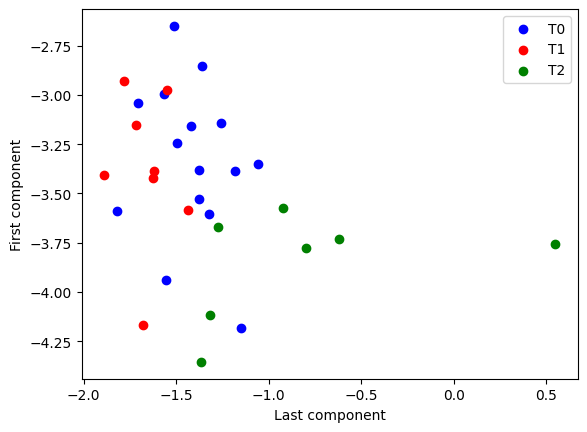

In [251]:
plot_scatter(trials_logvar[cl0], trials_logvar[cl1], trials_logvar[cl2])

Classifier Training

In [252]:
# Percentage of trials to use for training (50-50 split here)
train_percentage = 0.5

# Calculate the number of trials for each class the above percentage boils down to
ntrain_rest = int(trials_filt[cl0].shape[2] * train_percentage)
ntrain_r = int(trials_filt[cl1].shape[2] * train_percentage)
ntrain_l = int(trials_filt[cl2].shape[2] * train_percentage)

In [253]:
ntest_rest = trials_filt[cl0].shape[2] - ntrain_rest
ntest_r = trials_filt[cl1].shape[2] - ntrain_r
ntest_l = trials_filt[cl2].shape[2] - ntrain_l

# Splitting the frequency filtered signal into a train and test set
train = {cl0: trials_filt[cl0][:,:,:ntrain_rest],
         cl1: trials_filt[cl1][:,:,:ntrain_r],
         cl2: trials_filt[cl2][:,:,:ntrain_l]}

test = {cl0: trials_filt[cl0][:,:,:ntrain_rest],
        cl1: trials_filt[cl1][:,:,ntrain_r:],
        cl2: trials_filt[cl2][:,:,ntrain_l:]}

Train the CSP on the training set only

In [254]:
W = csp(train[cl0], train[cl1], train[cl2])

In [255]:
train[cl1].shape


(64, 656, 4)

In [256]:
W.shape

(64, 64)

Apply the CSP on both the training and test set

In [257]:
train[cl0] = apply_mix(W, train[cl0])
train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl0]  = apply_mix(W, test[cl0])
test[cl1]  = apply_mix(W, test[cl1])
test[cl2]  = apply_mix(W, test[cl2])

In [258]:
train[cl1].shape

(64, 656, 4)

Select only the first and last components for classification

In [259]:
comp = np.array([0,-1])

train[cl0] = train[cl0][comp,:,:]
train[cl1] = train[cl1][comp,:,:]
train[cl2] = train[cl2][comp,:,:]
test[cl0]  = test[cl0][comp,:,:]
test[cl1]  = test[cl1][comp,:,:]
test[cl2]  = test[cl2][comp,:,:]

In [260]:
train[cl1].shape

(2, 656, 4)

Calculate the log-var

In [261]:
train[cl0] = logvar(train[cl0])
train[cl1] = logvar(train[cl1])
train[cl2] = logvar(train[cl2])
test[cl0]  = logvar(test[cl0])
test[cl1]  = logvar(test[cl1])
test[cl2]  = logvar(test[cl2])

In [262]:
train[cl1].shape

(2, 4)

In [263]:
train[cl1].T

array([[-1.74430129, -2.78935217],
       [-1.9641816 , -3.08373833],
       [-1.98603108, -3.40234708],
       [-1.66647672, -3.51672619]])

LDA

In [264]:
def train_lda(class0, class1, class2):
    '''
    Trains the LDA algorithm.
    arguments:
        class1 - An array (observations x features) for class 1
        class2 - An array (observations x features) for class 2
    returns:
        The projection matrix W
        The offset b
    '''
    nclasses = 3
    
    nclass0 = class0.shape[0]
    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]

    # Class priors: in this case, we have an equal number of training
    # examples for each class, so both priors are 0.5
    prior0 = nclass0 / float(nclass0 + nclass1)
    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass1)

    mean0 = np.mean(class0, axis=0)
    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)

    
    class0_centered = class0 - mean0
    class1_centered = class1 - mean1
    class2_centered = class2 - mean2

    # Calculate the covariance between the features
    cov0 = class0_centered.T.dot(class0_centered) / (nclass0 - nclasses)
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)

    W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)

    return (W,b)

def apply_lda(test, W, b):
    '''
    Applies a previously trained LDA to new data.
    arguments:
        test - An array (features x trials) containing the data
        W    - The project matrix W as calculated by train_lda()
        b    - The offsets b as calculated by train_lda()
    returns:
        A list containing a classlabel for each trial
    '''
    ntrials = test.shape[1]

    prediction = []
    for i in range(ntrials):
        # The line below is a generalization for:
        # result = W[0] * test[0,i] + W[1] * test[1,i] - b
        result = W.dot(test[:,i]) - b
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)

    return np.array(prediction)

In [265]:
W,b = train_lda(train[cl0].T, train[cl1].T, train[cl2].T)

print('W:', W)
print('b:', b)

W: [nan nan]
b: nan


C:\Users\erdes\AppData\Local\Temp\ipykernel_26332\2700634627.py:35: RuntimeWarning: divide by zero encountered in divide
  cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)


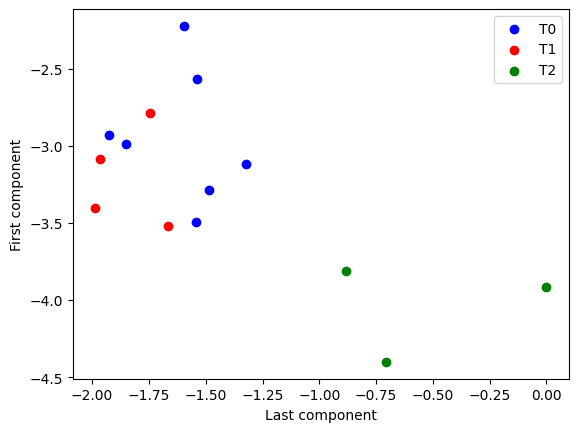

In [268]:
# Scatterplot like before
plot_scatter(train[cl0], train[cl1], train[cl2])
#title('Training data')

# Calculate decision boundary (x,y)
x = np.arange(-5, 1, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
#plt.xlim(-5, 1)
#plt.ylim(-2.2,1) 

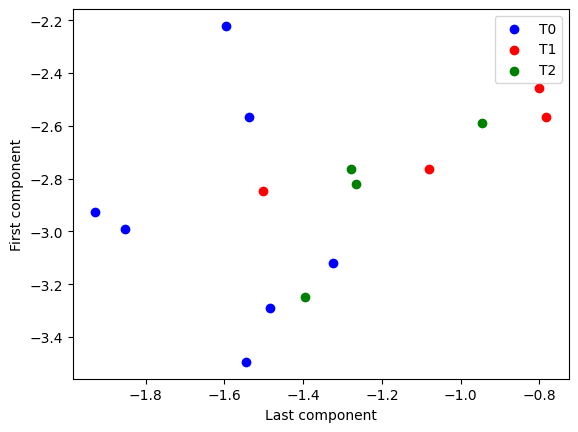

In [269]:
plot_scatter(test[cl0], test[cl1], test[cl2])
#title('Test data')
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
#plt.xlim(-5, 1)
#plt.ylim(-2.2, 1)

In [270]:
# Print confusion matrix
conf = np.array([
    [(apply_lda(test[cl1], W, b) == 1).sum(), (apply_lda(test[cl2], W, b) == 1).sum()],
    [(apply_lda(test[cl1], W, b) == 2).sum(), (apply_lda(test[cl2], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print('Accuracy: %.3f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))


Confusion matrix:
[[0 0]
 [4 4]]
Accuracy: 0.500
